# Bottom-up

## Agregación local
Algoritmo de crecimiento de regiones, en el cual se selecciona un píxel semilla y se expanden los píxeles vecinos basándose en un criterio de similitud.

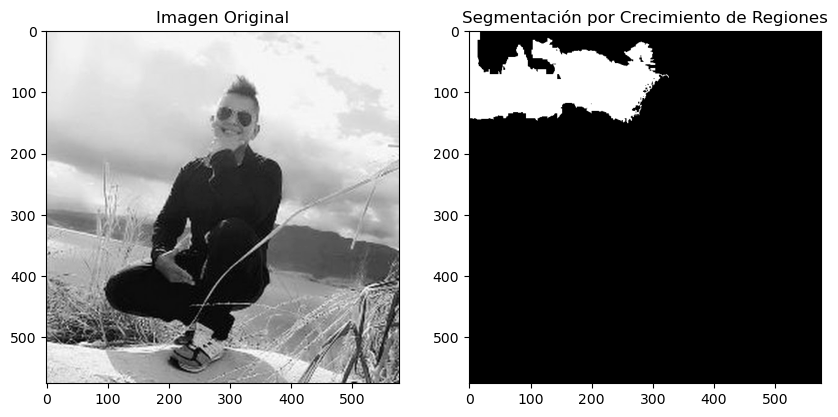

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Importar matplotlib para mostrar la imagen en el notebook


# Cargar la imagen en escala de grises

imagen = cv2.imread('../unir/percepcion-computacional/perfil.jpg', cv2.IMREAD_GRAYSCALE)

# Crear una imagen para almacenar los resultados de la segmentación
segmentacion = np.zeros_like(imagen)

# Definir el umbral de similitud
umbral_similitud = 10

# Píxel semilla
semilla_x, semilla_y = 100, 100

# Lista de píxeles a procesar (inicialmente contiene solo la semilla)
pila_procesamiento = [(semilla_x, semilla_y)]

# Valor de la semilla para comparar
valor_inicial = imagen[semilla_x, semilla_y]

# Mientras haya píxeles en la pila para procesar
while pila_procesamiento:
    x, y = pila_procesamiento.pop()
    
    # Si el píxel aún no ha sido procesado
    if segmentacion[x, y] == 0:
        # Verificar la similitud del píxel
        if abs(int(imagen[x, y]) - int(valor_inicial)) < umbral_similitud:
            # Marcar el píxel como parte de la región
            segmentacion[x, y] = 255
            
            # Añadir los píxeles vecinos a la pila para procesar
            if x > 0: pila_procesamiento.append((x-1, y))
            if x < imagen.shape[0] - 1: pila_procesamiento.append((x+1, y))
            if y > 0: pila_procesamiento.append((x, y-1))
            if y < imagen.shape[1] - 1: pila_procesamiento.append((x, y+1))


# Mostrar la imagen segmentada
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imagen, cmap='gray')
plt.title('Imagen Original')

plt.subplot(1, 2, 2)
plt.imshow(segmentacion, cmap='gray')
plt.title('Segmentación por Crecimiento de Regiones')

plt.show()

## Agregación Global
Los superpíxeles son grupos de píxeles similares que se agrupan en bloques más grandes. Esto permite una segmentación más global en comparación con la técnica de crecimiento de regiones.

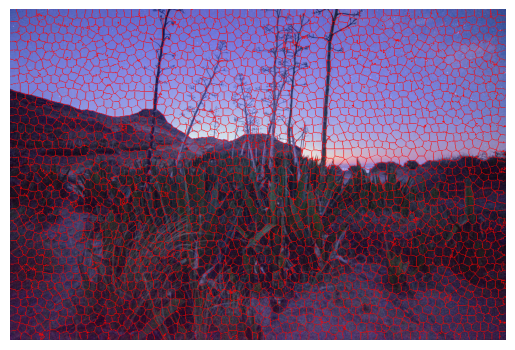

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen en color
imagen = cv2.imread('../unir/percepcion-computacional/desierto.jpg', cv2.IMREAD_COLOR)

# Convertir la imagen a LAB (para que los superpíxeles se basen en color)
lab_imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2Lab)

# Inicializar el algoritmo de superpíxeles (SLIC - Simple Linear Iterative Clustering)
superpixeles = cv2.ximgproc.createSuperpixelSLIC(lab_imagen, region_size=15, ruler=10.0)

# Ejecutar el algoritmo
superpixeles.iterate(10)

# Obtener la máscara de superpíxeles
mascara_superpixeles = superpixeles.getLabelContourMask()

# Dibujar los bordes de los superpíxeles en la imagen original
imagen_con_superpixeles = imagen.copy()
imagen_con_superpixeles[mascara_superpixeles == 255] = [0, 0, 255]  # Pinta los bordes en rojo

# Mostrar la imagen con los superpíxeles segmentados
plt.imshow(cv2.cvtColor(imagen_con_superpixeles, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# SPLIT AND MERGE

/var/folders/jt/szp4qsfj2h7823c8c0ysns6h0000gp/T/ipykernel_16327/4016377863.py:49: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  imagen_segmentada[y:y+alto, x:x+ancho] = etiqueta
/var/folders/jt/szp4qsfj2h7823c8c0ysns6h0000gp/T/ipykernel_16327/4016377863.py:49: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 257 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  imagen_segmentada[y:y+alto, x:x+ancho] = etiqueta
/var/folders/jt/szp4qsfj2h7823c8c0ysns6h0000gp/T/ipykernel_16327/4016377863.py:49: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers

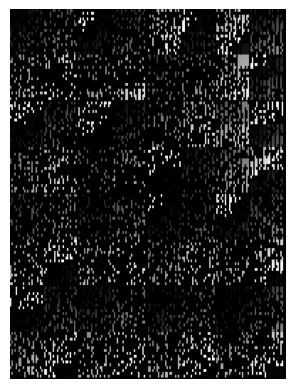

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dividir_region(imagen, x, y, ancho, alto, umbral_varianza):
    # Extraer la subimagen
    subimagen = imagen[y:y+alto, x:x+ancho]
    
    # Calcular la varianza de la intensidad en la subimagen
    varianza = np.var(subimagen)
    
    # Si la varianza es menor que el umbral, la región es homogénea
    if varianza < umbral_varianza:
        return [(x, y, ancho, alto)]
    else:
        # Si la región no es homogénea, dividirla en 4 partes
        mitad_ancho = ancho // 2
        mitad_alto = alto // 2
        
        # Recursivamente dividir cada cuadrante
        regiones = []
        if mitad_ancho > 0 and mitad_alto > 0:
            regiones.extend(dividir_region(imagen, x, y, mitad_ancho, mitad_alto, umbral_varianza))
            regiones.extend(dividir_region(imagen, x + mitad_ancho, y, mitad_ancho, mitad_alto, umbral_varianza))
            regiones.extend(dividir_region(imagen, x, y + mitad_alto, mitad_ancho, mitad_alto, umbral_varianza))
            regiones.extend(dividir_region(imagen, x + mitad_ancho, y + mitad_alto, mitad_ancho, mitad_alto, umbral_varianza))
        
        return regiones

def merge_regions(regiones, imagen, umbral_similitud):
    # Inicializar una imagen segmentada
    imagen_segmentada = np.zeros_like(imagen)
    
    # Etiqueta de región
    etiqueta = 1
    
    for (x, y, ancho, alto) in regiones:
        # Extraer subimagen
        subimagen = imagen[y:y+alto, x:x+ancho]
        
        # Calcular la media de intensidad en la subimagen
        media_intensidad = np.mean(subimagen)
        
        # Unir las regiones que tengan similaridad dentro del umbral
        if np.mean(np.abs(imagen_segmentada - media_intensidad)) < umbral_similitud:
            imagen_segmentada[y:y+alto, x:x+ancho] = etiqueta
        else:
            etiqueta += 1
            imagen_segmentada[y:y+alto, x:x+ancho] = etiqueta
    
    return imagen_segmentada

# Cargar la imagen en escala de grises
imagen = cv2.imread('../unir/percepcion-computacional/hacker.jpeg', cv2.IMREAD_GRAYSCALE)

# Definir el umbral para la varianza (para la división) y el umbral de similitud (para la unión)
umbral_varianza = 10 #500
umbral_similitud = 10 #10

# Dividir la imagen en regiones homogéneas
regiones_divididas = dividir_region(imagen, 0, 0, imagen.shape[1], imagen.shape[0], umbral_varianza)

# Unir las regiones que sean similares
imagen_segmentada = merge_regions(regiones_divididas, imagen, umbral_similitud)

# Mostrar la imagen segmentada
plt.imshow(imagen_segmentada, cmap='gray')
plt.axis('off')
plt.show()

Aumento de la varianza: Si aumentas el umbral de varianza, el algoritmo será menos sensible a las diferencias de intensidad dentro de una región. Esto significa que regiones con más variabilidad en intensidad (más heterogéneas) serán tratadas como homogéneas y no se dividirán en subregiones. 

Disminución de la similitud: Si disminuyes el umbral de similitud, el algoritmo será más estricto al unir regiones. Esto significa que solo regiones muy similares serán fusionadas. Como resultado:
Más regiones distintas: Las regiones segmentadas serán más distintas entre sí, ya que sólo se unirán aquellas que tienen intensidades muy similares.
Segmentación más detallada: La imagen segmentada tendrá más regiones con bordes más definidos, ya que solo se fusionarán regiones que son casi idénticas en términos de intensidad.

## Gradient Vector Flow (GVF) - Flujo de Vectores de Gradiente.

In [25]:
pip install numpy scikit-image matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.


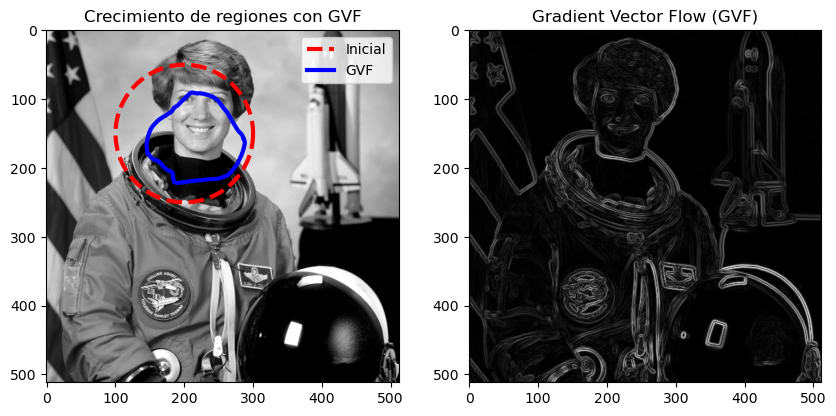

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, io, img_as_float
from skimage.filters import sobel
from skimage.segmentation import active_contour
from scipy.ndimage import gaussian_gradient_magnitude

# Cargar una imagen de ejemplo de scikit-image
image = img_as_float(data.astronaut())  # Imagen de ejemplo (astronauta)
gray_image = color.rgb2gray(image)      # Convertir a escala de grises

# Calculamos la magnitud del gradiente usando Sobel
gradient = sobel(gray_image)

# Aplicamos una aproximación simple del flujo del gradiente
gvf = gaussian_gradient_magnitude(gradient, sigma=1)

# Definir la curva inicial (serpiente) para ajustar el contorno
s = np.linspace(0, 2*np.pi, 400)
x = 200 + 100*np.cos(s)
y = 150 + 100*np.sin(s)
init = np.array([x, y]).T

# Aplicamos la función active_contour (serpiente) usando el gradiente GVF
contour = active_contour(gvf, init, alpha=0.1, beta=0.1, gamma=0.01)

# Visualización de resultados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gray_image, cmap='gray')
ax[0].plot(init[:, 0], init[:, 1], '--r', lw=3, label="Inicial")
ax[0].plot(contour[:, 0], contour[:, 1], '-b', lw=3, label="GVF")
ax[0].set_title('Crecimiento de regiones con GVF')
ax[0].legend()

ax[1].imshow(gvf, cmap='gray')
ax[1].set_title('Gradient Vector Flow (GVF)')
plt.show()

## Watershed (cuencas hidrográficas)

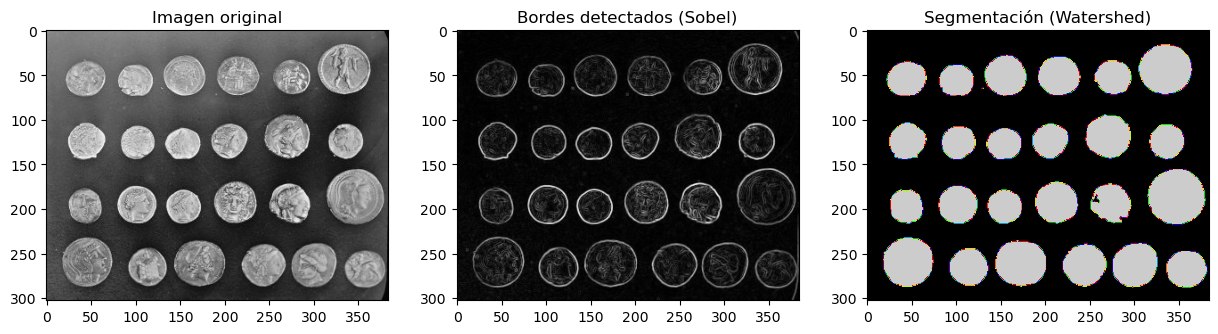

In [6]:
import numpy as np
import cv2
from skimage import data, color, io
from skimage.filters import sobel
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

# Cargar una imagen de ejemplo (imagen de monedas ya en escala de grises)
image = data.coins()  # Esta imagen ya está en escala de grises
# Si quieres usar tu imagen subida, descomentar la línea siguiente
# image = io.imread('/mnt/data/image.png')

# Aplicar el filtro Sobel para obtener los bordes de la imagen
edges = sobel(image)  # Ya no se necesita convertir a escala de grises

# Generar marcadores para identificar las regiones
markers = np.zeros_like(image)
markers[image < 30] = 1  # Marcadores de fondo
markers[image > 150] = 2  # Marcadores de primer plano

# Aplicar el algoritmo watershed
elevation_map = sobel(image)
segmentation = watershed(elevation_map, markers)

# Mostrar resultados
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Imagen original')

# Bordes detectados
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Bordes detectados (Sobel)')

# Resultado de Watershed
ax[2].imshow(segmentation, cmap='nipy_spectral')
ax[2].set_title('Segmentación (Watershed)')

plt.show()
plt.show()

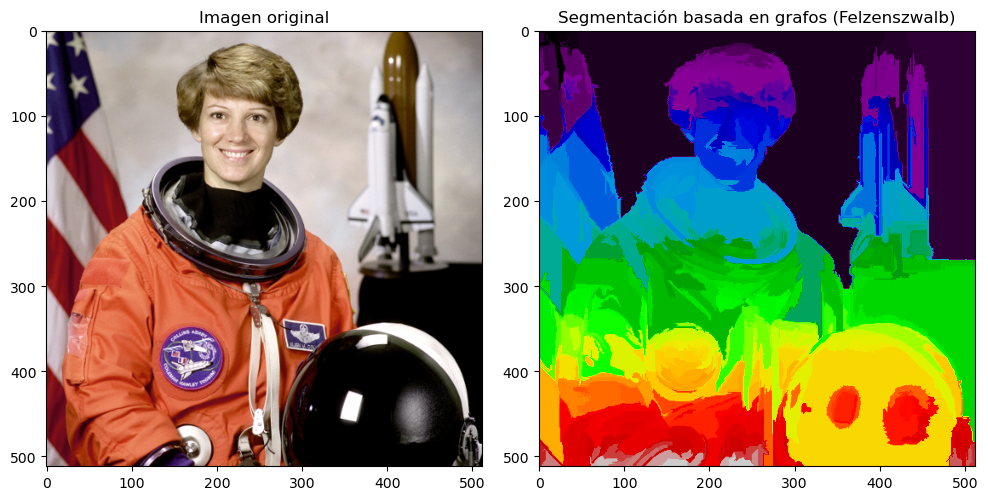

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray

# Cargar una imagen de ejemplo
image = data.astronaut()  # Imagen RGB de ejemplo (astronauta)
gray_image = rgb2gray(image)  # Convertir la imagen a escala de grises

# Aplicar la segmentación basada en grafos usando el algoritmo de Felzenszwalb
# scale: parámetro que controla el tamaño de las regiones
# sigma: controla la suavidad de la imagen (preprocesamiento con un filtro gaussiano)
# min_size: tamaño mínimo de las regiones
segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

# Visualización de los resultados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
ax[0].imshow(image)
ax[0].set_title("Imagen original")

# Imagen segmentada
ax[1].imshow(segments, cmap="nipy_spectral")
ax[1].set_title("Segmentación basada en grafos (Felzenszwalb)")

# Mostrar gráficos
plt.tight_layout()
plt.show()